<a href="https://colab.research.google.com/github/JRamos84/deteccion_fraude/blob/main/02_Data_Cleaning_and_Preprocessing_selection_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 02 Data Cleaning and Preprocessing
**Objetivo**: Limpiar y preprocesar los datos para que estén listos para el modelado.
**Contenido**:
- Manejo de valores nulos.
- Creación de nuevas características (feature engineering).
- Conversión de tipos de datos.
- Codificación de variables categóricas.
- Normalización y estandarización de las variables.


In [188]:
# Librerías
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
from scipy import stats
import datetime
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

In [189]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce el uso de memoria de un DataFrame de pandas cambiando los tipos de datos de las columnas numéricas
    a tipos más eficientes sin perder información.

    Parameters:
    df (pd.DataFrame): El DataFrame a optimizar.
    verbose (bool): Si es True, imprime el uso de memoria antes y después de la optimización.

    Returns:
    pd.DataFrame: El DataFrame optimizado.
    """
    # Obtener el uso inicial de memoria
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            # Optimización para tipos de datos enteros
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # Optimización para tipos de datos flotantes
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    # Obtener el uso final de memoria
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Mem. usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')

    return df

In [190]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:

## Cargamos los dataset de train_transaction y train_identity
df_transaction_train = pd.read_csv(data_dir + '/train_transaction.csv')
df_identity_train = pd.read_csv(data_dir + '/train_identity.csv')
## Reducimos los tamaños de los dataset cambiando los tipos de los datos de las columnas
df_transaction_train = reduce_mem_usage(df_transaction_train)
df_identity_train = reduce_mem_usage(df_identity_train)

Mem. usage decreased to 867.89 Mb (58.7% reduction)
Mem. usage decreased to 138.38 Mb (12.2% reduction)


In [192]:

# Combinar los datasets
data = pd.merge(df_transaction_train, df_identity_train, on='TransactionID', how='left')


In [193]:
dataset = data.copy()

## Consideración principales del análisis de EDA

### Manejo de valores nulos

- Usaremos las columnas que no superen el 50 de los valores nulos

In [194]:
null_percentages = (dataset.isnull().sum() / len(dataset)) * 100
null_percentages[null_percentages < 50].sort_values(ascending=False)

M4               47.658753
D2               47.549192
V1               47.293494
V10              47.293494
D11              47.293494
                   ...    
C12               0.000000
C13               0.000000
C14               0.000000
isFraud           0.000000
TransactionID     0.000000
Length: 220, dtype: float64

In [195]:
col_util = null_percentages[null_percentages < 20].index.to_list()

In [196]:
dataset = dataset[col_util]
dataset.shape

(590540, 182)

In [197]:
## Eliminamos las filas nulas
dataset.dropna(inplace=True)
dataset.shape

(346886, 182)

- La cantidad de registro dismuyo considerablemente luego de la elimación de las columnas y las filas con datos nulos

### Rango de TransactionAMT y Aplicación del Logaritmo

- Basado en el análisis EDA elinamos los registro con valores en TransactionAMT superior a 5192

In [198]:
dataset = dataset[dataset['TransactionAmt'] < 5192]

In [199]:
dataset['TransactionAmt'] = np.log(dataset['TransactionAmt'])

####Convertiendo 'TransactionDT' en unidades de tiempo

In [200]:

# Suponiendo que dataset tiene las columnas 'TransactionDT'
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

# Convertir 'TransactionDT' a formato datetime
dataset['Date'] = dataset['TransactionDT'].apply(lambda x: startdate + datetime.timedelta(seconds=x))

# Verificar y asegurarse de que 'Date' sea de tipo datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Crear un DataFrame con las nuevas columnas a agregar
new_columns = pd.DataFrame({
    '_Weekdays': dataset['Date'].dt.dayofweek,
    '_Hours': dataset['Date'].dt.hour,
    '_Days': dataset['Date'].dt.day
})

# Unir todas las columnas al DataFrame original
dataset = pd.concat([dataset, new_columns], axis=1)

# Convertir las nuevas columnas a tipo 'object' si es necesario
dataset['_Weekdays'] = dataset['_Weekdays'].astype('object')
dataset['_Hours'] = dataset['_Hours'].astype('object')
dataset['_Days'] = dataset['_Days'].astype('object')

# Eliminar las columnas innecesarias
dataset.drop(['Date', 'TransactionDT'], axis=1, inplace=True)

# Mostrar los primeros 3 registros del DataFrame modificado
print(dataset.head(3))

   TransactionID  isFraud  TransactionAmt ProductCD  card1  card2  card3  \
1        2987001        0        3.367188         W   2755  404.0  150.0   
2        2987002        0        4.078125         W   4663  490.0  150.0   
3        2987003        0        3.912109         W  18132  567.0  150.0   

        card4  card5   card6  ...  V315  V316    V317   V318  V319  V320  \
1  mastercard  102.0  credit  ...   0.0   0.0     0.0    0.0   0.0   0.0   
2        visa  166.0   debit  ...   0.0   0.0     0.0    0.0   0.0   0.0   
3  mastercard  117.0   debit  ...   0.0  50.0  1404.0  790.0   0.0   0.0   

   V321  _Weekdays  _Hours  _Days  
1   0.0          5       0      2  
2   0.0          5       0      2  
3   0.0          5       0      2  

[3 rows x 184 columns]


### Mapping emails

In [201]:
#https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt?scriptVersionId=18427966&cellId=116
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft',
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft',
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other',
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other',
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other',
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
#for c in ['P_emaildomain', 'R_emaildomain']:
for c in ['P_emaildomain']:
    dataset[c + '_bin'] = dataset[c].map(emails)
    dataset[c + '_suffix'] = dataset[c].map(lambda x: str(x).split('.')[-1])
    dataset[c + '_suffix'] = dataset[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

## Elimaamos las columnas 'P_emaildomain', 'R_emaildomain'
dataset.drop(['P_emaildomain'], axis=1, inplace=True)
### IMPORTANTE  'R_emaildomain' fue sacada del analisis debido a que tiene un elavado cantidad de valores nulos


## Separamos datos características (X) y variable objetivo (y)

In [202]:
X = dataset.drop('isFraud', axis=1)  # features
y = dataset['isFraud']  # target

## División de los Datos en Conjuntos de Entrenamiento y Prueba

### Criterios para la División de Datos

#### Entrenamiento (Training Set):
- Representa el 70% del conjunto de datos.
- Se utiliza para ajustar el modelo.

#### Validación (Validation Set):
- Representa el 15% del conjunto de datos.
- Se utiliza para ajustar los hiperparámetros y prevenir el sobreajuste.

#### Prueba (Test Set):
- Representa el 15% del conjunto de datos.
- Se utiliza para evaluar el rendimiento final del modelo.


In [203]:
X.shape, y.shape

((346874, 184), (346874,))

In [204]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y conjunto temporal (que se dividirá en validación y prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Dividir el conjunto temporal en conjunto de validación y conjunto de prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Mostrar las formas de los conjuntos de datos para asegurarse de que la estratificación se realizó correctamente
print("Forma del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Forma del conjunto de validación:", X_val.shape, y_val.shape)
print("Forma del conjunto de prueba:", X_test.shape, y_test.shape)

Forma del conjunto de entrenamiento: (242811, 184) (242811,)
Forma del conjunto de validación: (52031, 184) (52031,)
Forma del conjunto de prueba: (52032, 184) (52032,)


In [205]:
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

### Codificación de variables categóricas.


In [206]:
X_train.shape, X_val.shape, X_test.shape

((242811, 184), (52031, 184), (52032, 184))

In [207]:
X_train.select_dtypes(include=['object']).nunique()

ProductCD                4
card4                    4
card6                    3
_Weekdays                7
_Hours                  24
_Days                   31
P_emaildomain_bin        9
P_emaildomain_suffix     7
dtype: int64

In [208]:

# Copiar los DataFrames originales para evitar modificaciones directas
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()

# Crear un codificador de etiquetas con manejo de etiquetas nuevas
class SafeLabelEncoder(LabelEncoder):
    def fit(self, y):
        super().fit(y)
        self.classes_ = np.append(self.classes_, '<unknown>')  # Agregar una clase para etiquetas nuevas

    def transform(self, y):
        y_transformed = super().transform(y)
        # Mapear etiquetas nuevas a una categoría desconocida (por ejemplo, -1)
        y_transformed[y_transformed == -1] = len(self.classes_) - 1
        return y_transformed

# Inicializar SafeLabelEncoder
lbl = SafeLabelEncoder()

# Ajustar LabelEncoder con el conjunto de entrenamiento
for col in cat_cols:
    lbl.fit(X_train[col].astype(str))

    # Codificar columnas categóricas en el conjunto de entrenamiento
    X_train_encoded[col] = lbl.transform(X_train[col].astype(str))

    # Codificar columnas categóricas en el conjunto de validación y conjunto de prueba
    X_val_encoded[col] = lbl.transform(X_val[col].astype(str))
    X_test_encoded[col] = lbl.transform(X_test[col].astype(str))

# Mostrar los primeros registros de X_train_encoded después de la transformación
print("Primeros registros de X_train_encoded:")
print(X_train_encoded.head())

# Mostrar los primeros registros de X_val_encoded después de la transformación
print("\nPrimeros registros de X_val_encoded:")
print(X_val_encoded.head())

# Mostrar los primeros registros de X_test_encoded después de la transformación
print("\nPrimeros registros de X_test_encoded:")
print(X_test_encoded.head())

# Reconstruir los conjuntos de entrenamiento, validación y prueba finales con todas las columnas
X_train_final = pd.concat([X_train.drop(cat_cols, axis=1), X_train_encoded], axis=1)
X_val_final = pd.concat([X_val.drop(cat_cols, axis=1), X_val_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(cat_cols, axis=1), X_test_encoded], axis=1)

# Mostrar las formas de los conjuntos finales para verificar
print("\nForma del conjunto de entrenamiento final:", X_train_final.shape, y_train.shape)
print("Forma del conjunto de validación final:", X_val_final.shape, y_val.shape)
print("Forma del conjunto de prueba final:", X_test_final.shape, y_test.shape)

Primeros registros de X_train_encoded:
        TransactionID  TransactionAmt  ProductCD  card1  card2  card3  card4  \
249325        3236325        3.968750          3  12577  268.0  150.0      3   
450425        3437425        4.476562          3  16630  242.0  150.0      3   
208066        3195066        4.078125          3   1917  174.0  150.0      3   
535394        3522394        6.496094          3   1444  490.0  150.0      3   
292258        3279258        4.371094          3   2300  412.0  150.0      3   

        card5  card6  addr1  ...  V317  V318  V319  V320  V321  _Weekdays  \
249325  166.0      1  205.0  ...   0.0   0.0   0.0   0.0   0.0          2   
450425  166.0      1  264.0  ...   0.0   0.0   0.0   0.0   0.0          3   
208066  195.0      1  330.0  ...   0.0   0.0   0.0   0.0   0.0          3   
535394  166.0      1  299.0  ...   0.0   0.0   0.0   0.0   0.0          6   
292258  226.0      1  494.0  ...   0.0   0.0   0.0   0.0   0.0          3   

        _Hours  _

### Normalización y estandarización de las variables.

In [209]:
scaler_min_max = MinMaxScaler()
X_train_final[num_cols] = scaler_min_max.fit_transform(X_train_final[num_cols])
X_test_final[num_cols] = scaler_min_max.transform(X_test_final[num_cols])
X_val_final[num_cols] = scaler_min_max.transform(X_val_final[num_cols])



In [210]:
X_train.shape

(242811, 184)

### Aplicación de PCA

In [211]:
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza explicada
X_train_pca = pca.fit_transform(X_train_final)
X_val_pca = pca.transform(X_val_final)
X_test_pca = pca.transform(X_test_final)

In [212]:
# Número de componentes principales seleccionados
n_components = pca.n_components_
print(f'Número de componentes principales seleccionados: {n_components}')

Número de componentes principales seleccionados: 4


In [213]:
X_train_final.shape

(242811, 360)

In [214]:
covar_matrix = PCA(n_components=X_train_final.shape[1])
covar_matrix.fit(X_train_final)

PCA(n_components=360)

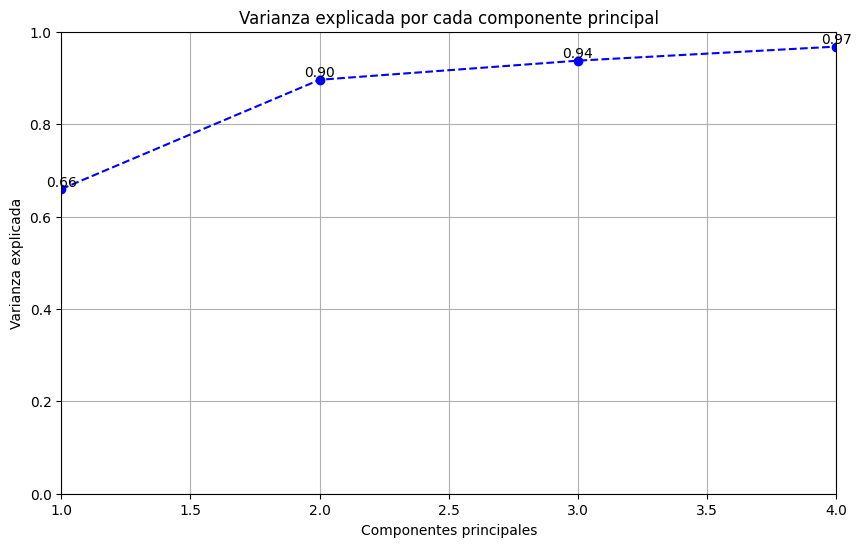

In [215]:

# Genera el gráfico de la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.ylabel('Varianza explicada')
plt.xlabel('Componentes principales')
plt.title('Varianza explicada por cada componente principal')

# Agrega etiquetas a cada punto del gráfico
for i, value in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(i + 1, value, f'{value:.2f}', ha='center', va='bottom')

# Ajusta los límites del eje x para mostrar todos los componentes
plt.xlim(1, len(pca.explained_variance_ratio_))
plt.ylim(0, 1)  # La varianza explicada acumulada estará entre 0 y 1

# Muestra el gráfico
plt.grid(True)
plt.savefig('nulo_menor_10.png', format='png')
plt.show()




Se probó ajustando el porcentaje de valores permitidos por columna para maximizar la cantidad de columnas utilizadas en el análisis de componentes principales (PCA). Los resultados mostraron que el número máximo de componentes principales (PCA) obtenidos es de 4 cuando se permiten columnas con hasta un 20% de valores faltantes:

- Columnas con menos del 10% de valores faltantes: 3 componentes
- Columnas con menos del 20% de valores faltantes: 4 componentes
- Columnas con menos del 50% de valores faltantes: 4 componentes
- Columnas con menos del 60% de valores faltantes: 4 componentes

Se observó que la máxima varianza se logra con un número reducido de componentes principales, lo cual indica que gran parte de la información se puede capturar eficientemente con pocos componentes.

Por lo tanto vamos a trabajas con columnas que no tengan más del 20 de valores nulos.

In [216]:
# Guardar X y y en archivos CSV

#dir_data_processed = '../data/processed'
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_X_train = os.path.join(dir_data_processed, 'X__train_procesados.csv')
ruta_archivo_X_test = os.path.join(dir_data_processed, 'X_test_procesados.csv')
ruta_archivo_X_val = os.path.join(dir_data_processed, 'X_val_procesados.csv')

ruta_archivo_y_train = os.path.join(dir_data_processed, 'y_train_procesados.csv')
ruta_archivo_y_test = os.path.join(dir_data_processed, 'y_test_procesados.csv')
ruta_archivo_y_val = os.path.join(dir_data_processed, 'y_val_procesados.csv')


X_train_final.to_csv(ruta_archivo_X_train, index=False, encoding='utf-8')
X_val_final.to_csv(ruta_archivo_X_val, index=False, encoding='utf-8')
X_test_final.to_csv(ruta_archivo_X_test, index=False, encoding='utf-8')

y_train.to_csv(ruta_archivo_y_train, index=False, encoding='utf-8')
y_val.to_csv(ruta_archivo_y_val, index=False, encoding='utf-8')
y_test.to_csv(ruta_archivo_y_test, index=False, encoding='utf-8')



In [217]:
y_train.shape

(242811,)